In [ ]:
import os
import time
import gc
import argparse
import sys
import urllib
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lower
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics

# from azure.common.client_factory import get_client_from_cli_profile
# import azure.mgmt.cosmosdb
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.webservice import Webservice, AksWebservice
from azureml.exceptions import WebserviceException
from azureml.core import Environment
from azureml.core.environment import CondaDependencies
from azureml.core.model import InferenceConfig
from azureml.core.environment import SparkPackage
import pydocumentdb.document_client as document_client

%matplotlib inline
print("Azure SDK version:", azureml.core.VERSION)

Azure SDK version: 1.54.0


In [ ]:
# initial spark
spark = SparkSession \
    .builder \
    .appName("Movie Recommender ALS") \
    .getOrCreate()

Add your Azure subscription ID

In [ ]:
# Add your subscription ID
subscription_id_input = "your-key" #exmaple: "xxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx"

# Set your workspace name
workspace_name = "azureML-movie"
# resource_group = "{}The-Movie-System".format(workspace_name)
resource_group = "The-Movie-System"

# Set your region to deploy Azure ML workspace
location = "eastus"

# AzureML service and Azure Kubernetes Service prefix
service_name = "aks-movie"

In [ ]:
# CosmosDB
# account_name for CosmosDB cannot have "_" and needs to be less than 31 chars
# account_name = "{}cosmosdb-system".format(workspace_name).replace("_", "-")[:31]
account_name = "cosmosdb-system"
cosmos_database = "rcmmovie"
cosmos_collection = "ctnrcmmovie"

# AzureML resource names
model_name = "{}-reco.mml".format(service_name)
# aks_name = "{}-aks".format(service_name)
aks_name = service_name

In [ ]:
# Copyright (c) Recommenders contributors.
# Licensed under the MIT License.
import pydocumentdb.errors as errors


def find_collection(client, dbid, id):
    """Find whether or not a CosmosDB collection exists.

    Args:
        client (object): A pydocumentdb client object.
        dbid (str): Database ID.
        id (str): Collection ID.

    Returns:
        bool: True if the collection exists, False otherwise.
    """
    database_link = "dbs/" + dbid
    collections = list(
        client.QueryCollections(
            database_link,
            {
                "query": "SELECT * FROM r WHERE r.id=@id",
                "parameters": [{"name": "@id", "value": id}],
            },
        )
    )
    if len(collections) > 0:
        return True
    else:
        return False


def read_collection(client, dbid, id):
    """Read a CosmosDB collection.

    Args:
        client (object): A pydocumentdb client object.
        dbid (str): Database ID.
        id (str): Collection ID.

    Returns:
        object: A collection.
    """
    try:
        database_link = "dbs/" + dbid
        collection_link = database_link + "/colls/{0}".format(id)
        collection = client.ReadCollection(collection_link)
        return collection
    except errors.DocumentDBError as e:
        if e.status_code == 404:
            print("A collection with id '{0}' does not exist".format(id))
        else:
            raise errors.HTTPFailure(e.status_code)


def read_database(client, id):
    """Read a CosmosDB database.

    Args:
        client (object): A pydocumentdb client object.
        id (str): Database ID.

    Returns:
        object: A database.
    """
    try:
        database_link = "dbs/" + id
        database = client.ReadDatabase(database_link)
        return database
    except errors.DocumentDBError as e:
        if e.status_code == 404:
            print("A database with id '{0}' does not exist".format(id))
        else:
            raise errors.HTTPFailure(e.status_code)


def find_database(client, id):
    """Find whether or not a CosmosDB database exists.

    Args:
        client (object): A pydocumentdb client object.
        id (str): Database ID.

    Returns:
        bool: True if the database exists, False otherwise.
    """
    databases = list(
        client.QueryDatabases(
            {
                "query": "SELECT * FROM r WHERE r.id=@id",
                "parameters": [{"name": "@id", "value": id}],
            }
        )
    )
    if len(databases) > 0:
        return True
    else:
        return False

In [ ]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
# MOVIELENS_DATA_SIZE = '100k'

In [ ]:
# userCol = "UserId"
# itemCol = "MovieId"
# ratingCol = "Rating"

train_data_path = "train"
test_data_path = "test"

Import or create the AzureML Workspace.

In [ ]:
ws = Workspace.create(
    name=workspace_name,
    subscription_id=subscription_id_input,
    resource_group=resource_group, 
    location=location,
    exist_ok=True
)

Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.


Create a Cosmos DB to store recommendation results

In [ ]:
from azure.identity import DefaultAzureCredential
from azure.mgmt.cosmosdb import CosmosDBManagementClient
from azure.mgmt.cosmosdb.models import DatabaseAccountCreateUpdateParameters

In [ ]:
# # explicitly pass subscription_id in case user has multiple subscriptions
# client = get_client_from_cli_profile(
#     azure.mgmt.cosmosdb.CosmosDB,
#     subscription_id=subscription_id
# )
subscription_id = subscription_id_input

# Create a Cosmos DB management client
credentials = DefaultAzureCredential()
cosmosdb_client = CosmosDBManagementClient(credentials, subscription_id)

In [ ]:
master_key = "key of your cosmosdb"
endpoint = "https://" + account_name + ".documents.azure.com:443/"

# DB client
client = document_client.DocumentClient(endpoint, {'masterKey': master_key})

if not find_database(client, cosmos_database):
    db = client.CreateDatabase({'id': cosmos_database })
    print("Database created")
else:
    db = read_database(client, cosmos_database)
    print("Database found")

# Create collection options
options = dict(offerThroughput=11000)

# Create a collection
collection_definition = {
    'id': cosmos_collection,
    'partitionKey': {'paths': ['/id'],'kind': 'Hash'}
}
if not find_collection(client, cosmos_database, cosmos_collection):
    collection = client.CreateCollection(
        db['_self'], 
        collection_definition,
        options
    )
    print("Collection created")
else:
    collection = read_collection(client, cosmos_database, cosmos_collection)
    print("Collection found")
    
dbsecrets = dict(
    Endpoint=endpoint, 
    Masterkey=master_key, 
    Database=cosmos_database, 
    Collection=cosmos_collection, 
    Upsert=True
)


Database found
Collection found


Training

In [ ]:
jdbcHostname = "dev-the-movie-system.database.windows.net"
jdbcDatabase = "dev-rcm-movie"
jdbcPort = 1433
jdbcUrl = "jdbc:sqlserver://{0}:{1};database={2}".format(jdbcHostname, jdbcPort, jdbcDatabase)
connectionProperties = {
"user" : "the-movie",
"password" : "your-password",
"driver" : "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

In [ ]:
# Đọc dữ liệu
movies_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[W_THE_MOVIE_D]", properties=connectionProperties)
display(movies_df)

MOVIE_ID MOVIE_NAME GENRE MOVIE_DATE COUNTRY URL_POSTER OVERVIEW DIRECTOR 1183993.0 Chamán [] 2023-09-05T00:00:00Z Peru https://image.tmdb.org/t/p/w500/qhGXZ16N4PaPpp5Rl0JBZnZtbJC.jpg The old Shaman makes his last trip to the Amazon jungle in search of a special beeswax for arrows that he learned to make when he had not yet been contacted by Western culture 1133349.0 Taungsu [] 2023-06-02T00:00:00Z Myanmar https://image.tmdb.org/t/p/w500/hjhlBZdH8brapjIUdr4qkwcCb9o.jpg Plot Unknown 974169.0 Day 13 ['Thriller', 'Horror'] 2023-04-21T00:00:00Z Egypt https://image.tmdb.org/t/p/w500/cFmSA1lAoK34WtgqYoPO7vRgJN9.jpg A horror feature that tells the story of Ezz El-Din, who returns from abroad after many years, looking for his family, and while staying at his family's mansion, he discovers an unexpected adventure. Wael Abdullah 1037348.0 As Long As We Both Shall Live ['Drama', 'Romance', 'Fantasy'] 2023-03-17T00:00:00Z Japan https://image.tmdb.org/t/p/w500/yYbBsAA1eh3hioW4Jm0G775TZk0.jpg An unhappy young woman from an abusive family is married off to a fearsome and chilly army commander. But the two learn more about each other, love may have a chance. Ayuko Tsukahara 1062343.0 No Direction Home ['Drama'] 2023-02-11T00:00:00Z Japan https://image.tmdb.org/t/p/w500/crIDprSM6OnuLQGA1yxkOb8XMfk.jpg After missing the last train after their best friend’s wedding, Ko, Reiji, and Yasumasa are dropped off at a small train station in the countryside. A teacher, a salaried worker, and an aspiring painter, three people with vague anxieties walk the dark streets at night and pour out their thoughts. Taishi Nakagawa 1110405.0 In My Heart ['Drama', 'Romance'] 2022-11-23T00:00:00Z Germany https://image.tmdb.org/t/p/w500/sWgVN4jdn9N2j25BDjny8CYcJ2M.jpg Adele is afraid of the outside world. She is depressed. She can't leave her house anymore. So Alice joins her to understand what is eating away at her. Victor Boulenger 1172108.0 My Therapist Gives Me A Special Treatment [] 2022-08-08T00:00:00Z https://image.tmdb.org/t/p/w500/l7tiNH4Nsz0eiDelpTeaqIj5Idm.jpg Therapists are an essential part of life for some folks, and watching this wonderful offering from the guys at Amsterdam Amateurs its pretty obvious why especially if the treatment theyre offering is any way like the kind that these fellows provide. No wonder the hardcore sluts here are so keen to make their sessions part and parcel of their weekly routines. Zoe Davis, Rachel Rose and Debby Pleasure just can't wait to get down on that couch; opening up like never before, and taking every thick, meaty inch of cock thats on offer in the process. It's more than enough to leave them changed women; as they climax again and again on those penetrating ramrods. In short, a top-notch mental and physical workout each and every time! 990393.0 Walk with the Storm ['Documentary', 'Family'] 2022-06-18T00:00:00Z https://image.tmdb.org/t/p/w500/zvCPk0WuFhOLOJCsUEMd5VuiDfk.jpg In a small town, the funeral of a matriarch brings about the reunion of family members, many returning to the village after leading new lives elsewhere, some no longer speaking the language of the native land. With the passage of time, the big clan becomes fragmented as members, like other modern Chinese in mainland China, face changes in lives, ideals, and family structures. The occasion becomes a hot ground for deals and negotiations that are inevitable amid the rapid development of China, where family members prosper while relationships become calculated. Still, a funeral procession amid an impending storm requires them, already down different paths, to walk together. Lam Tung-hei 973667.0 Garten sprengen [] 2022-04-05T00:00:00Z Austria Shortly after their arrival in California, they became the target of intense FBI investigations, which resulted in an elaborate series of wiretapping, tailing, and burglaries that would last six years. Veronika Eberhart 933238.0 Footsteps ['Thriller', 'Horror'] 2022-01-31T00:00:00Z https://image.tmdb.org/t/p/w5

In [ ]:
users_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[W_USER_D]", properties=connectionProperties)
display(users_df)

USER_ID FULL_NAME GENDER BIRTH_DATE ADDRESS USERNAME PASSWORD ID0001 Triệu Văn Kiểm female 13/06/2001 Bình Dương, Việt Nam christopherduran 9^AhGo^!!5 ID0002 Bùi Quốc Lĩnh male 29/04/2005 Bình Dương, Việt Nam dware *Fnj$6SxAC ID0003 Mạc Văn Tuân female 16/06/2002 Hậu Giang, Việt Nam sarah83 _h6JFi$fd_ ID0004 Tôn Quốc Phục male 27/03/2008 Đắk Nông, Việt Nam andrewszachary 6O)59D3soX ID0005 Phạm Doãn Thắng female 10/05/1982 Long An, Việt Nam browneric i1Rz6xSC!l ID0006 Nguyễn Đăng Tùng male 02/07/2004 Yên Bái, Việt Nam edward58 T9@aXWs3&# ID0007 Mạc Hữu Hoàn male 07/04/2003 Sơn La, Việt Nam ulawrence #*M0AWhj5q ID0008 Trịnh Quốc Doanh female 28/12/1991 Đồng Nai, Việt Nam vwarren #U@4UwOf6B ID0009 Hồ Quốc Em female 02/11/2000 Gia Lai, Việt Nam pfowler RJK9CKt9l+ ID0010 Hoàng Văn Toản male 23/08/1999 Hải Phòng, Việt Nam jmccarthy qG0P1gjon( ID0011 Đinh Quốc Toàn female 15/08/1999 Sơn La, Việt Nam brianchen 1yDFfnt4#6 ID0012 Tôn Hữu Hoàn female 16/11/2003 Đắk Nông, Việt Nam ctran )9RjOVRqFJ ID0013 Phan Thị Triều female 12/06/1989 Long An, Việt Nam hollyanderson 3nMV&zgX!a ID0014 Phan Văn Quyền male 08/10/1995 Hải Phòng, Việt Nam jamesjacobs %aCw_9@hr3 ID0015 Hoàng Văn Tùng male 25/04/1999 Trà Vinh, Việt Nam claudialopez )d*1Q6cy*8 ID0016 Nguyễn Hữu San female 07/01/2004 Sóc Trăng, Việt Nam matthewbaker 2gVM(2kd)2 ID0017 Trần Ngọc Tùng female 15/09/1989 Trà Vinh, Việt Nam rodgersjoshua %j8LxnjHAe ID0018 Hồ Đăng Toản female 19/01/2004 Bắc Kạn, Việt Nam brandimoore (9fVJIHh_N ID0019 Tôn Văn Doanh female 26/02/1998 Phú Thọ, Việt Nam spencejessica %YmKNzNUy9 ID0020 Mạc Quốc Ly male 09/08/1998 Khánh Hòa, Việt Nam robinlewis @c4l7X*yLa ID0021 Phạm Văn Dung female 31/03/1999 Hậu Giang, Việt Nam taylor40 yMkY6lCh$H ID0022 Trần Doãn Độ male 08/08/2002 Nam Định, Việt Nam scott49 cO0INuho#^ ID0023 Trần Doãn Doanh male 14/09/2000 Hậu Giang, Việt Nam christiangrant a(5WlFhKny ID0024 Phan Đăng Thắng female 13/11/2003 Sóc Trăng, Việt Nam gkent VI8dDmN8)S ID0025 Hoàng Hữu Ly male 13/05/2005 Lào Cai, Việt Nam allison86 URY$5RYsb) ID0026 Ngô Thị Tuấn female 03/02/1999 Phú Thọ, Việt Nam emilywright _LVPcg0QI3 ID0027 Triệu Doãn Doanh female 24/07/2007 Bình Phước, Việt Nam sabrina23 kj1Wt_%z+w ID0028 Ngô Ngọc Thắng female 02/02/2005 Quảng Bình, Việt Nam nicholas40 ^r8U(wgc04 ID0029 Ngô Quốc Triều male 09/08/2004 Bình Định, Việt Nam williamstracy S1r3Uub$)@ ID0030 Ngô Thị Tuấn male 24/10/2000 Hà Giang, Việt Nam deborahlee (_Mt@l8G%0 ID0031 Trần Hữu Doanh male 16/08/2009 Hòa Bình, Việt Nam jarvisheather ^8OSl2es0W ID0032 Ngô Quốc Thuyết male 13/05/2001 Quảng Bình, Việt Nam jonathan82 $3N@AJjs6w ID0033 Triệu Quốc Sơn male 23/04/2003 Hải Dương, Việt Nam daniel60 _H7Kow92dC ID0034 Tôn Thị Tuân male 15/08/1997 Phú Yên, Việt Nam christensenkim &4#EMKD(d5 ID0035 Phan Quốc Thắng male 10/03/1983 An Giang, Việt Nam bentleylorraine __h3WJopV@ ID0036 Hoàng Quốc Ánh female 05/02/2003 Hòa Bình, Việt Nam gwalker +1gK)^Tz7s ID0037 Phan Quốc Lĩnh male 09/03/1999 Hà Nội, Việt Nam smccoy +0$(CqDAeG ID0038 Bùi Ngọc Thuyết female 30/11/2005 Bắc Ninh, Việt Nam kevinshea (6*&wk6tzA ID0039 Hồ Doãn Toàn male 13/02/1998 Khánh Hòa, Việt Nam francisjoseph Id6X8XnM^* ID0040 Triệu Văn Em female 18/09/2003 Nam Định, Việt Nam leeellen UH4CZDdof! ID0041 Tôn Văn Tùng female 14/12/1991 Hòa Bình, Việt Nam nelsonrobin Uwk_6Qkm(4 ID0042 Hoàng Doãn Quyền female 10/11/2004 Điện Biên, Việt Nam daltonsimmons F&jW1SDNPh ID0043 Hồ Thị Cảnh male 11/04/2005 Đồng Nai, Việt Nam cstephens hq%O3TjpaX ID0044 Hoàng Văn Kiểm male 11/07/1999 Đắk Lắk, Việt Nam annette24 w!2BEi)iS^ ID0045 Lý Văn Ánh female 16/08/1999 Bắc Ninh, Việt Nam melissa14 h7+*9XiLn& ID0046 Lý Đăng Doanh female 17/05/2004 Bình Định, Việt Nam cainregina 2%W5OKlgN6 ID0047 Trịnh Quốc Kiểm female 04/06/1999 Bến Tre, Việt Nam hudsonluis 7c4hFy)z@l ID0048 Lê Doãn Thuyết male 14/08/2003 Bình Phước, Việt Nam bradley80 ^JNNZjzU52 ID0049 Hồ Quốc Tuân female 16/03/1999 Thái Bình, Việt Nam kaylayu Y&$2VuGlPl ID0050 Tôn Ngọc Ánh female 11/09/1998 Bế

In [ ]:
history_watch_df = spark.read.jdbc(url=jdbcUrl, table="[DWH].[WATCH_MOVIE_F]", properties=connectionProperties)
history_watch_df = history_watch_df.withColumnRenamed("MOVIE-ID", "MOVIE_ID")
display(history_watch_df)

USER_ID MOVIE_ID LIKE_MOVIE DATE_WATCH RATING ID0001 488.0 false 23-11-2023 2.0 ID0001 56734.0 false 23-05-2023 4.0 ID0001 144852.0 false 15-10-2023 6.0 ID0001 25072.0 false 20-03-2023 1.0 ID0001 13.0 false 26-08-2023 2.0 ID0001 6968.0 true 01-11-2023 10.0 ID0001 58006.0 true 26-05-2023 9.0 ID0001 1640.0 false 22-02-2023 2.0 ID0001 78798.0 false 13-08-2023 5.0 ID0001 504.0 false 29-09-2023 4.0 ID0001 27163.0 false 04-06-2023 5.0 ID0001 4808.0 false 09-09-2023 6.0 ID0001 45379.0 true 15-02-2023 7.0 ID0001 61263.0 false 20-11-2023 3.0 ID0001 6365.0 true 31-03-2023 7.0 ID0001 29369.0 false 09-03-2023 5.0 ID0001 240145.0 false 19-01-2023 1.0 ID0001 55636.0 true 28-03-2023 8.0 ID0001 4960.0 false 14-06-2023 3.0 ID0001 27972.0 true 31-10-2023 10.0 ID0001 10912.0 true 07-04-2023 7.0 ID0001 12763.0 true 20-08-2023 7.0 ID0001 61134.0 true 17-03-2023 10.0 ID0002 31167.0 true 30-01-2023 7.0 ID0002 7180.0 true 16-02-2023 7.0 ID0002 30614.0 true 26-10-2023 10.0 ID0002 819.0 true 18-11-2023 9.0 ID0002 155.0 false 05-02-2023 1.0 ID0002 4959.0 false 15-01-2023 3.0 ID0002 8338.0 false 21-03-2023 5.0 ID0002 11662.0 false 01-04-2023 1.0 ID0002 21041.0 false 13-06-2023 1.0 ID0002 62.0 true 21-06-2023 9.0 ID0002 956.0 false 19-04-2023 1.0 ID0002 13022.0 false 26-06-2023 3.0 ID0002 43135.0 false 20-05-2023 1.0 ID0002 9030.0 false 14-07-2023 4.0 ID0002 13548.0 false 19-11-2023 5.0 ID0002 27428.0 false 06-10-2023 3.0 ID0002 10431.0 true 10-11-2023 10.0 ID0002 11701.0 false 18-06-2023 4.0 ID0002 85.0 true 27-08-2023 8.0 ID0002 106725.0 true 01-11-2023 10.0 ID0002 10859.0 false 07-04-2023 6.0 ID0002 11006.0 false 11-11-2023 5.0 ID0002 59817.0 false 04-01-2023 6.0 ID0002 78147.0 false 04-05-2023 1.0 ID0002 69597.0 false 07-10-2023 2.0 ID0002 40036.0 false 17-09-2023 3.0 ID0002 933238.0 false 17-08-2023 2.0 ID0002 41419.0 true 15-09-2023 10.0 ID0002 20089.0 false 24-04-2023 1.0 ID0002 66.0 true 04-03-2023 7.0 ID0002 36669.0 false 13-05-2023 3.0 ID0002 2165.0 false 09-08-2023 1.0 ID0002 77700.0 false 30-07-2023 3.0 ID0002 53714.0 false 25-03-2023 3.0 ID0002 15135.0 false 16-09-2023 5.0 ID0002 66107.0 false 28-08-2023 4.0 ID0002 4174.0 true 16-01-2023 9.0 ID0002 169337.0 true 04-09-2023 10.0 ID0002 4937.0 false 21-10-2023 5.0 ID0002 54812.0 false 27-09-2023 2.0 ID0002 9281.0 false 29-04-2023 4.0 ID0002 45379.0 false 22-10-2023 1.0 ID0002 6968.0 false 22-07-2023 4.0 ID0002 17288.0 true 13-02-2023 8.0 ID0002 3124.0 true 16-10-2023 7.0 ID0003 886.0 false 17-01-2023 2.0 ID0003 3087.0 false 27-03-2023 4.0 ID0003 2169.0 false 15-11-2023 4.0 ID0003 22123.0 false 23-01-2023 3.0 ID0003 55636.0 true 07-03-2023 8.0 ID0003 116.0 false 22-10-2023 3.0 ID0003 39545.0 false 20-06-2023 4.0 ID0003 12132.0 true 05-06-2023 9.0 ID0003 6384.0 true 26-07-2023 9.0 ID0003 4688.0 true 16-02-2023 10.0 ID0003 19.0 false 24-11-2023 4.0 ID0003 1067849.0 false 03-09-2023 1.0 ID0003 155.0 false 10-09-2023 4.0 ID0003 15336.0 false 27-01-2023 5.0 ID0003 240145.0 false 26-07-2023 5.0 ID0003 66.0 false 03-04-2023 3.0 ID0003 37995.0 true 21-08-2023 9.0 ID0003 851784.0 false 29-09-2023 6.0 ID0003 27811.0 false 15-01-2023 4.0 ID0003 108.0 true 10-04-2023 10.0 ID0003 52851.0 true 18-06-2023 7.0 ID0003 4512.0 true 30-07-2023 10.0 ID0003 1248.0 false 11-07-2023 2.0 ID0003 4959.0 false 27-06-2023 1.0 ID0003 1269.0 true 19-03-2023 8.0 ID0003 49001.0 false 01-08-2023 6.0 ID0003 11006.0 false 18-02-2023 6.0 ID0003 18352.0 false 08-07-2023 5.0 ID0003 6279.0 true 14-09-2023 7.0 ID0003 11181.0 false 23-03-2023 2.0 ID0003 3131.0 true 03-11-2023 9.0 ID0003 41091.0 false 29-01-2023 2.0 ID0003 38673.0 false 02-01-2023 5.0 ID0003 1059597.0 false 05-08-2023 1.0 ID0003 198.0 true 14-04-2023 7.0 ID0003 8338.0 false 05-05-2023 5.0 ID0003 4173.0 false 13-05-2023 1.0 ID0003 21549.0 false 28-02-2023 1.0 ID0003 14409.0 true 23-08-2023 8.0 ID0003 5723.0 true 05-03-2023 8.0 ID0003 289.0 false 19-09-2023 6.0 ID0003 2165.0 false 14-11-2023 6.0 ID0003 4495.0 false 25-08-2023 4.0 ID0003 45379.0 false 21-11-2023 1.0 ID0003 

In [ ]:
# Join history_watch_df và movies_df
history_movies_df = history_watch_df.join(movies_df, history_watch_df.MOVIE_ID == movies_df.MOVIE_ID, "left")

# Join kết quả với users_df
data_frame = history_movies_df.join(users_df, history_movies_df.USER_ID == users_df.USER_ID, "left")

In [ ]:
# Lọc ra các cột cần thiết cho ALS
als_input_df = data_frame.select(history_watch_df.USER_ID, history_watch_df.MOVIE_ID, history_watch_df.RATING)
display(als_input_df)

USER_ID MOVIE_ID RATING ID0001 488.0 2.0 ID0001 56734.0 4.0 ID0001 144852.0 6.0 ID0001 25072.0 1.0 ID0001 13.0 2.0 ID0001 6968.0 10.0 ID0001 58006.0 9.0 ID0001 1640.0 2.0 ID0001 78798.0 5.0 ID0001 504.0 4.0 ID0001 27163.0 5.0 ID0001 4808.0 6.0 ID0001 45379.0 7.0 ID0001 61263.0 3.0 ID0001 6365.0 7.0 ID0001 29369.0 5.0 ID0001 240145.0 1.0 ID0001 55636.0 8.0 ID0001 4960.0 3.0 ID0001 27972.0 10.0 ID0001 10912.0 7.0 ID0001 12763.0 7.0 ID0001 61134.0 10.0 ID0002 31167.0 7.0 ID0002 7180.0 7.0 ID0002 30614.0 10.0 ID0002 819.0 9.0 ID0002 155.0 1.0 ID0002 4959.0 3.0 ID0002 8338.0 5.0 ID0002 11662.0 1.0 ID0002 21041.0 1.0 ID0002 62.0 9.0 ID0002 956.0 1.0 ID0002 13022.0 3.0 ID0002 43135.0 1.0 ID0002 9030.0 4.0 ID0002 13548.0 5.0 ID0002 27428.0 3.0 ID0002 10431.0 10.0 ID0002 11701.0 4.0 ID0002 85.0 8.0 ID0002 106725.0 10.0 ID0002 10859.0 6.0 ID0002 11006.0 5.0 ID0002 59817.0 6.0 ID0002 78147.0 1.0 ID0002 69597.0 2.0 ID0002 40036.0 3.0 ID0002 933238.0 2.0 ID0002 41419.0 10.0 ID0002 20089.0 1.0 ID0002 66.0 7.0 ID0002 36669.0 3.0 ID0002 2165.0 1.0 ID0002 77700.0 3.0 ID0002 53714.0 3.0 ID0002 15135.0 5.0 ID0002 66107.0 4.0 ID0002 4174.0 9.0 ID0002 169337.0 10.0 ID0002 4937.0 5.0 ID0002 54812.0 2.0 ID0002 9281.0 4.0 ID0002 45379.0 1.0 ID0002 6968.0 4.0 ID0002 17288.0 8.0 ID0002 3124.0 7.0 ID0003 886.0 2.0 ID0003 3087.0 4.0 ID0003 2169.0 4.0 ID0003 22123.0 3.0 ID0003 55636.0 8.0 ID0003 116.0 3.0 ID0003 39545.0 4.0 ID0003 12132.0 9.0 ID0003 6384.0 9.0 ID0003 4688.0 10.0 ID0003 19.0 4.0 ID0003 1067849.0 1.0 ID0003 155.0 4.0 ID0003 15336.0 5.0 ID0003 240145.0 5.0 ID0003 66.0 3.0 ID0003 37995.0 9.0 ID0003 851784.0 6.0 ID0003 27811.0 4.0 ID0003 108.0 10.0 ID0003 52851.0 7.0 ID0003 4512.0 10.0 ID0003 1248.0 2.0 ID0003 4959.0 1.0 ID0003 1269.0 8.0 ID0003 49001.0 6.0 ID0003 11006.0 6.0 ID0003 18352.0 5.0 ID0003 6279.0 7.0 ID0003 11181.0 2.0 ID0003 3131.0 9.0 ID0003 41091.0 2.0 ID0003 38673.0 5.0 ID0003 1059597.0 1.0 ID0003 198.0 7.0 ID0003 8338.0 5.0 ID0003 4173.0 1.0 ID0003 21549.0 1.0 ID0003 14409.0 8.0 ID0003 5723.0 8.0 ID0003 289.0 6.0 ID0003 2165.0 6.0 ID0003 4495.0 4.0 ID0003 45379.0 1.0 ID0003 65529.0 5.0 ID0004 81685.0 9.0 ID0004 17832.0 3.0 ID0004 47296.0 10.0 ID0004 43135.0 6.0 ID0004 73968.0 8.0 ID0004 1182725.0 10.0 ID0004 149894.0 2.0 ID0005 42191.0 3.0 ID0005 11478.0 5.0 ID0005 33411.0 7.0 ID0005 1030513.0 7.0 ID0005 115146.0 7.0 ID0005 69122.0 1.0 ID0005 212208.0 8.0 ID0005 66.0 8.0 ID0005 26723.0 6.0 ID0005 58369.0 6.0 ID0005 776.0 6.0 ID0005 46593.0 1.0 ID0005 192.0 1.0 ID0005 123725.0 7.0 ID0005 10912.0 3.0 ID0005 2282.0 9.0 ID0005 2692.0 6.0 ID0005 63.0 6.0 ID0005 66446.0 7.0 ID0005 3087.0 7.0 ID0005 19034.0 3.0 ID0005 8891.0 4.0 ID0005 88995.0 8.0 ID0005 3417.0 9.0 ID0005 13920.0 6.0 ID0005 2227.0 5.0 ID0005 3131.0 8.0 ID0005 55085.0 9.0 ID0005 62.0 2.0 ID0005 1059597.0 10.0 ID0005 3036.0 10.0 ID0005 118545.0 9.0 ID0005 934.0 6.0 ID0005 6968.0 3.0 ID0005 64.0 8.0 ID0005 125025.0 4.0 ID0005 58058.0 6.0 ID0005 2203.0 6.0 ID0005 21245.0 3.0 ID0005 8784.0 3.0 ID0005 20.0 7.0 ID0005 2956.0 2.0 ID0005 1153569.0 4.0 ID0005 30082.0 10.0 ID0005 13.0 5.0 ID0005 133.0 1.0 ID0005 11701.0 9.0 ID0005 1181313.0 4.0 ID0005 54882.0 9.0 ID0005 2039.0 5.0 ID0005 13023.0 2.0 ID0005 5723.0 9.0 ID0005 51856.0 8.0 ID0005 53650.0 4.0 ID0005 9030.0 7.0 ID0005 18182.0 4.0 ID0005 10990.0 5.0 ID0005 4517.0 4.0 ID0005 72855.0 10.0 ID0005 206.0 4.0 ID0005 131273.0 1.0 ID0005 72466.0 3.0 ID0005 93491.0 9.0 ID0005 26510.0 8.0 ID0005 886.0 10.0 ID0005 13014.0 7.0 ID0005 1245.0 3.0 ID0005 25541.0 10.0 ID0005 18897.0 10.0 ID0005 39995.0 9.0 ID0005 237455.0 10.0 ID0005 2165.0 4.0 ID0005 110.0 8.0 ID0005 36672.0 6.0 ID0005 2393.0 9.0 ID0005 68812.0 7.0 ID0005 1896.0 7.0 ID0005 49001.0 3.0 ID0006 19.0 1.0 ID0006 933238.0 7.0 ID0006 26473.0 4.0 ID0006 658.0 1.0 ID0006 39995.0 6.0 ID0006 9278.0 8.0 ID0006 41421.0 2.0 ID0006 3490.0 5.0 ID0006 53714.0 5.0 ID0006 31167.0 10.0 ID0006 2462.0 7.0 ID0006 66.0 6.0 ID0006 106725.0 5.0 ID0006 1067849.0 2.0 ID0006 6968.0 6.0 ID0006 1

In [ ]:
als_input_df = als_input_df.withColumn('USER_ID', col('USER_ID').substr(3, 4).cast('int'))
als_input_df = als_input_df.withColumn('MOVIE_ID', col('MOVIE_ID').cast(IntegerType()))
# Xem kết quả
als_input_df.show()


+-------+--------+------+
|USER_ID|MOVIE_ID|RATING|
+-------+--------+------+
|      1|    6968|  10.0|
|      1|   25072|   1.0|
|      1|   56734|   4.0|
|      1|   27972|  10.0|
|      1|   45379|   7.0|
|      1|  144852|   6.0|
|      1|    1640|   2.0|
|      1|   10912|   7.0|
|      1|   58006|   9.0|
|      1|   61263|   3.0|
|      1|   55636|   8.0|
|      1|    4960|   3.0|
|      1|   78798|   5.0|
|      1|   29369|   5.0|
|      1|     504|   4.0|
|      1|     488|   2.0|
|      1|  240145|   1.0|
|      1|      13|   2.0|
|      1|   27163|   5.0|
|      1|    6365|   7.0|
+-------+--------+------+
only showing top 20 rows



In [ ]:
# Chuyển DataFrame sang RDD với mỗi hàng là một đối tượng Row
als_input_rdd = als_input_df.rdd

# Nếu bạn muốn chuyển đổi mỗi hàng thành một tuple
als_input_rdd = als_input_rdd.map(lambda row: (row.USER_ID, row.MOVIE_ID, row.RATING))

In [ ]:
als_input_rdd.take(5)

[(1, 488, 2.0),
 (1, 56734, 4.0),
 (1, 144852, 6.0),
 (1, 25072, 1.0),
 (1, 13, 2.0)]

In [ ]:
# Hàm kiểm tra xem một dòng dữ liệu có chứa giá trị None hay không
def contains_none(row):
    return None in row

# Lọc ra các dòng có chứa giá trị None
none_rows = als_input_rdd.filter(contains_none)

# Đếm số lượng dòng có chứa giá trị None
num_none_rows = none_rows.count()

if num_none_rows > 0:
    print(f"Có {num_none_rows} dòng chứa giá trị None.")
else:
    print("Không có dòng nào chứa giá trị None.")
# In ra số lượng dòng hiện tại
num_rows_before = als_input_rdd.count()
print(f"Số lượng dòng hiện tại: {num_rows_before}")

Có 2 dòng chứa giá trị None.
Số lượng dòng hiện tại: 44970


In [ ]:
# Hàm kiểm tra xem một dòng dữ liệu không chứa giá trị None
def not_contains_none(row):
    return None not in row

# Lọc ra các dòng không chứa giá trị None
als_input_rdd = als_input_rdd.filter(not_contains_none)

# Kiểm tra số lượng dòng sau khi lọc
num_rows_after = als_input_rdd.count()
print(f"Số lượng dòng sau khi lọc: {num_rows_after}")

Số lượng dòng sau khi lọc: 44968


In [ ]:
# Define the split ratios for training, validation, and test datasets
split_ratio = [0.7, 0.1, 0.2]

# Split the data into train, validation, and test datasets
train, val, test = als_input_rdd.randomSplit(split_ratio)

In [ ]:
train.take(5)

[(1, 488, 2.0),
 (1, 56734, 4.0),
 (1, 25072, 1.0),
 (1, 13, 2.0),
 (1, 6968, 10.0)]

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_params, ranks, nonnegative=True):
    best_rmse = float("inf")
    best_rank = -1
    best_reg_param = 0
    best_model = None
    best_params = {}
    errors = []

    for rank in ranks:
        for reg_param in reg_params:
            # Huấn luyện mô hình ALS với tùy chọn nonnegative
            model = ALS.train(
                train_data, 
                rank, 
                num_iters, 
                reg_param, 
                nonnegative=nonnegative
            )

            # Dự đoán trên tập validation
            valid_data_rdd = validation_data.map(lambda x: (x[0], x[1]))
            predictions = model.predictAll(valid_data_rdd).map(lambda r: ((r[0], r[1]), r[2]))
            rates_and_preds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

            # Tính RMSE
            rmse = math.sqrt(RegressionMetrics(rates_and_preds.map(lambda x: x[1])).meanSquaredError)
            # add to errors
            errors.append(rmse)
            if rmse < best_rmse:
                best_rmse = rmse
                best_rank = rank
                best_reg_param = reg_param
                best_model = model
                best_params = {'rank': best_rank, 'regularization': best_reg_param, 'rmse': best_rmse}

    print(f"Best model: rank {best_rank}, regularization {best_reg_param}, RMSE {best_rmse}")
    return best_model, best_params, errors


In [ ]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]
errors = []
# grid search and select best model
start_time = time.time()
best_model, best_params, errors = train_ALS(train, val, num_iterations, reg_params, ranks)
print("Best parameters:", best_params)
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Best model: rank 8, regularization 0.2, RMSE 3.327076373381089
Best parameters: {'rank': 8, 'regularization': 0.2, 'rmse': 3.327076373381089}
Total Runtime: 329.19 seconds


In [ ]:
best_model.save(sc, model_name)


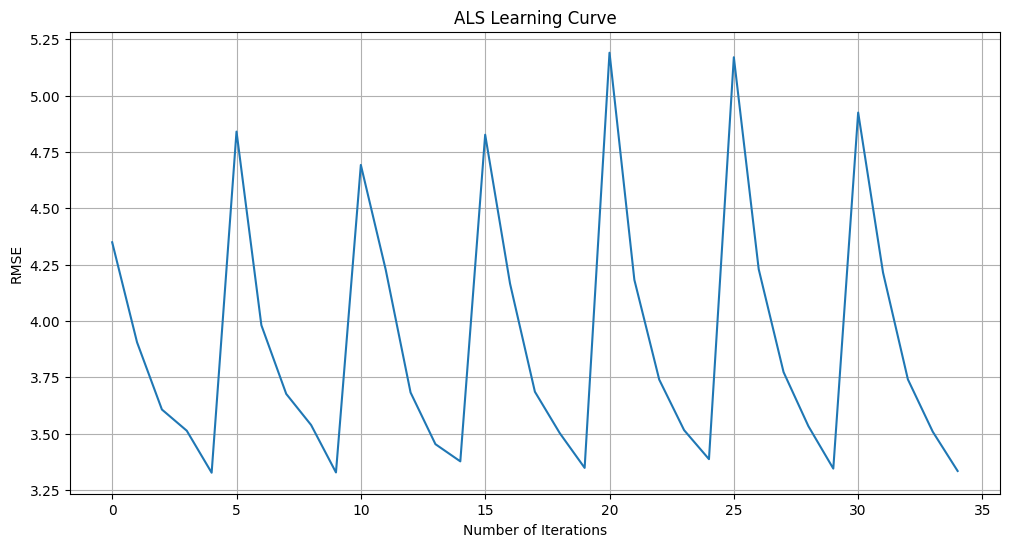

In [ ]:
# Plot function to show learning curve of ALS

# Tạo một danh sách x từ 0 đến len(errors) - 1
x_values = list(range(len(errors)))

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(x_values, errors)
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('ALS Learning Curve')
plt.grid(True)
plt.show()

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = best_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))

# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

# get the RMSE
rmse = math.sqrt(RegressionMetrics(ratesAndPreds.map(lambda x: x[1])).meanSquaredError)
print(f"RMSE trên tập test: {rmse}")

RMSE trên tập test: 436357.87275912653


In [ ]:
# Thêm đánh giá của người dùng
def add_new_user_to_data(train_data, movieId_list, spark_context):
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, id, max_rating) for id in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)

In [ ]:
# return a rdd with the userid and all movies (except ones in movieId_list)
def get_inference_data(train_data, df_movies, movieId_list, spark_context):
    # Chuyển đổi movieId_list sang kiểu dữ liệu phù hợp
    movieId_list_double = [float(id) for id in movieId_list]

    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1

    # tạo broadcast variable
    broadcast_movieId_list = spark_context.broadcast(set(movieId_list_double))

    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in broadcast_movieId_list.value) \
        .map(lambda x: (new_id, x))

In [ ]:
def make_recommendation(best_params, als_input_rdd, df_movies, 
                        movieId_list, n_recommendations, spark_context):
    # modify train data by adding new user's rows
    train_data = add_new_user_to_data(als_input_rdd, movieId_list, spark_context)
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=10,
        rank=best_params.get('rank', None),
        lambda_=best_params.get('regularization', None),
        seed=99)

    # get inference rdd
    inference_rdd = get_inference_data(als_input_rdd, df_movies, movieId_list, spark_context)

    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    return topn_ids


In [ ]:
#make_recommendation return top_nids
def generate_recommendations(movie_ids):
    recommendations_data = [(movie_id, make_recommendation(
    best_params=best_params, 
    als_input_rdd=als_input_rdd, 
    df_movies=movies_df, 
    movieId_list=[movie_id], 
    n_recommendations=TOP_K, 
    spark_context=sc)) for movie_id in movie_ids]
    return recommendations_data



In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType,FloatType, ArrayType


In [ ]:
movie_ids_list = movies_df.select('MOVIE_ID').rdd.flatMap(lambda x: x).collect()

result_list = generate_recommendations(movie_ids_list)



In [ ]:
modified_list = [(int(t[0]), t[1]) for t in result_list]
modified_list[0]

In [ ]:
schema = StructType([
    StructField("MOVIE_ID", IntegerType()),
    StructField("RCM_MOVIE_ID", ArrayType(IntegerType()))
])
result_df = spark.createDataFrame(modified_list, schema)
result_df.show(truncate=False)

In [ ]:
display(result_df)

In [ ]:
test.show()

In [ ]:
account_name = "masterdatamovie"
account_key = "your key"
container_name = "tmdb-movie"
blob_name = "rcm_movie.csv"

spark.conf.set('fs.azure.account.key.' + account_name + '.blob.core.windows.net', account_key)
# Mount the Azure Storage container to DBFS
# dbutils.fs.mount(
#     source=f"wasbs://{container_name}@{account_name}.blob.core.windows.net",
#     mount_point="/mnt/data",
#     extra_configs={connection_string}
# )

filePath = "wasbs://" + container_name + "@" + account_name + ".blob.core.windows.net/" +blob_name
test_df = spark.read.format("csv").load(filePath, inferSchema = True, header = True)

# Read the CSV file using Spark
# test_df = spark.read.csv(f"/mnt/data/{blob_name}")

In [ ]:
display(test_df)

MOVIE_ID RCM_MOVIE_ID 1183993 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 1133349 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 974169 [5723,20186,26291,18082,231610,26510,51856,2393,11662,8891] 1037348 [8891,2393,20186,4688,5723,1269,84247,144852,64,39126] 1062343 [5723,20186,231610,51856,400,13240,2393,12795,26291,8785] 1110405 [26291,2393,144852,400,18082,132354,45379,10696,52869,14061] 1172108 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 990393 [51856,20186,132354,26291,5723,8891,4688,18082,231610,2203] 973667 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 933238 [20186,5723,18082,2393,26291,10859,231610,26510,41901,13240] 986808 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 932076 [5723,20186,231610,26291,18082,51856,144852,1269,13240,45379] 1202534 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 1016168 [8891,2393,26291,5723,20186,586,13242,41901,231610,144852] 587020 [20186,2393,8891,231610,26291,5723,400,1110405,144852,13240] 934289 [5723,26291,2393,20186,231610,400,8891,41901,51856,144852] 1130555 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 527313 [5723,20186,18082,26291,26510,400,13240,39126,64,51856] 543261 [26291,2393,41901,6383,20186,144852,11207,400,68676,1110405] 1181313 [26291,8891,2393,144852,13240,5723,20186,3,26510,18082] 550843 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 2203 [8891,2393,586,41901,26291,1110405,20186,5723,144852,1269] 1003260 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 1153231 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 41688 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 931520 [5723,20186,54882,18082,231610,41901,26291,13240,26510,2393] 304282 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 591173 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 54415 [5723,20186,2393,231610,13240,18082,51856,45379,26291,26510] 240145 [20186,51856,39126,18082,10959,26291,1110405,132354,212208,26510] 224181 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 139820 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 132213 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 68812 [586,8891,5723,20186,13240,84247,132354,6383,144852,2393] 109513 [5723,20186,51856,18082,26291,13240,12795,2393,8785,231610] 85034 [20186,5723,26291,41901,400,2393,18082,13240,51856,231610] 86654 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 78798 [18082,20186,5723,400,2393,586,8785,1269,10959,41901] 78147 [5723,20186,18082,26510,13240,2393,26291,8785,144852,231610] 74929 [5723,2393,20186,231610,1110405,18082,13240,41901,132354,26291] 74568 [51856,2393,20186,18082,5723,26291,14061,1951,8785,4688] 73421 [5723,20186,1110405,26291,18082,125025,144852,45379,1951,13240] 73269 [2393,5723,20186,26291,18082,144852,231610,1110405,8891,51856] 55779 [20186,5723,26291,13240,26510,18082,144852,41901,8891,1110405] 74539 [20186,5723,2393,231610,18082,13240,26291,41901,51856,1269] 1771 [5723,20186,18082,1269,2393,26510,4688,51856,231610,13240] 71070 [20186,8891,26291,5723,41901,2393,18082,26510,11207,51856] 65529 [2393,20186,5723,144852,51856,26510,18082,231610,1110405,13240] 212208 [20186,26291,1269,12795,1951,52404,11207,144852,231610,82943] 116514 [5723,20186,2393,18082,26291,26510,231610,1269,13240,11207] 61134 [2393,26291,5723,3293,20186,1110405,26510,82943,231610,18082] 212225 [20186,1269,13240,8891,2393,2203,8785,26510,586,11207] 73968 [5723,20186,2393,18082,144852,13240,932076,11662,26291,51856] 57298 [20186,5723,26291,8891,2393,1110405,41901,144852,82943,13240] 62784 [2393,20186,26291,51856,41901,586,54882,1951,18082,11207] 58369 [20186,41901,26291,13240,2393,231610,144852,586,54882,8785] 51072 [2393,20186,18082,26291,144852,8891,13240,26510,51856,132354] 71727 [20186,13240,18082,5723,2393,51856,1110405,26291,26510,8785] 85721 [5723,231610,20186,26291,144852,18082,111040

In [ ]:
master_key = "your key"#""
endpoint = "https://" + account_name + ".documents.azure.com:443/"
account_name = "cosmosdb-system"
cosmos_database = "rcmmovie"
cosmos_collection = "ctnrcmmovie"

dbsecrets = {
    "spark.cosmos.accountEndpoint": endpoint,
    "spark.cosmos.accountKey": master_key,
    "spark.cosmos.database": cosmos_database,
    "spark.cosmos.container": cosmos_collection,
    "spark.cosmos.write.upsert": True  # If Upsert is equivalent to Spark option write.upsert
}

In [ ]:
%fs refreshMounts

Mounts successfully refreshed.
res6: Boolean = true

In [ ]:
%fs ls dbfs:/FileStore/jars

path name size modificationTime dbfs:/FileStore/jars/5c00131d_d853_4e27_9e27_acc2d6f7cfee-azure_cosmos_spark_3_1_2_12_4_3_1-2ceec.jar 5c00131d_d853_4e27_9e27_acc2d6f7cfee-azure_cosmos_spark_3_1_2_12_4_3_1-2ceec.jar 17260424 1701767835000 dbfs:/FileStore/jars/bada8e94_2d3d_4c79_8a98_6f26142f7f58-azure_cosmos_spark_3_4_2_12_4_24_0-15142.jar bada8e94_2d3d_4c79_8a98_6f26142f7f58-azure_cosmos_spark_3_4_2_12_4_24_0-15142.jar 33958185 1701842479000 dbfs:/FileStore/jars/bb7c7c6b_713d_4b62_ace5_572b12a55616-azure_cosmos_spark_3_4_2_12_4_24_0-15142.jar bb7c7c6b_713d_4b62_ace5_572b12a55616-azure_cosmos_spark_3_4_2_12_4_24_0-15142.jar 33958185 1701835141000

In [ ]:
spark.conf.set("spark.jars.packages", "com.azure:azure_cosmos_spark_3_4_2_12_4_24_0")

In [ ]:
# Save data to CosmosDB
(test_df.coalesce(1)
 .write
 .format("com.microsoft.azure.cosmosdb.spark")
 .mode('overwrite')
 .options(**dbsecrets)
 .save())

In [ ]:
score_sparkml = """
import json
import pydocumentdb.document_client as document_client

def init(local=False):
    global client, collection
    try:
        client = document_client.DocumentClient('{endpoint}', dict(masterKey='{key}'))
        collection = client.ReadCollection(collection_link='dbs/{database}/colls/{collection}')
    except Exception as e:
        collection = e

def run(input_json):
    try:
        # Query them in SQL
        id = str(json.loads(json.loads(input_json)[0])['id'])
        query = dict(query='SELECT * FROM c WHERE c.id = "' + id +'"')
        options = dict(partitionKey=str(id))
        document_link = 'dbs/{database}/colls/{collection}/docs/' + id
        result = client.ReadDocument(document_link, options);  
    except Exception as e:
        result = str(e)
    return json.dumps(str(result))
""".format(key=dbsecrets['Masterkey'], 
           endpoint=dbsecrets['Endpoint'], 
           database=dbsecrets['Database'], 
           collection=dbsecrets['Collection'])

# test validity of python string
exec(score_sparkml)

with open("score_sparkml.py", "w") as file:
    file.write(score_sparkml)

In [ ]:
mymodel = Model.register(
    model_path=model_name,  # this points to a local file
    model_name=model_name,  # this is the name the model is registered as
    description="AML trained model",
    workspace=ws
)

print(mymodel.name, mymodel.description, mymodel.version)

In [ ]:
env = Environment(name='sparkmlenv')

# Specify a public image from microsoft/mmlspark as base image
env.docker.base_image="microsoft/mmlspark:0.15"

pip = [ 'azureml-defaults','numpy==1.14.2', 'scikit-learn==0.19.1', 'pandas','pydocumentdb']

# Add dependencies needed for inferencing
env.python.conda_dependencies = CondaDependencies.create(pip_packages=pip)
env.inferencing_stack_version = "latest"

# Add spark packages
env.spark.precache_packages = True
env.spark.repositories = ["https://mmlspark.azureedge.net/maven"]
env.spark.packages= [SparkPackage("com.microsoft.ml.spark", "mmlspark_2.11", "0.15"),SparkPackage("com.microsoft.azure", artifact="azure-storage", version="2.0.0"),SparkPackage(group="org.apache.hadoop", artifact="hadoop-azure", version="2.7.0")]

In [ ]:
# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    # Create the cluster using the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()
    aks_target = ComputeTarget.create(
        workspace=ws, 
        name=aks_name, 
        provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output = True)
    print(aks_target.provisioning_state)

In [ ]:
# Create an Inferencing Configuration with your environment and scoring script
inference_config = InferenceConfig(
    environment=env,
    entry_script="score_sparkml.py"
)

# Set the web service configuration (using default here with app insights)
aks_config = AksWebservice.deploy_configuration(enable_app_insights=True)

# Webservice creation using single command
try:
    aks_service = Model.deploy(
        workspace=ws,
        models=[mymodel],
        name=service_name,
        inference_config=inference_config,
        deployment_config=aks_config,
        deployment_target=aks_target
    )
    aks_service.wait_for_deployment(show_output=True)
except WebserviceException:
    # Retrieve existing service.
    aks_service = Webservice(ws, name=service_name)
    print("Retrieved existing service")